In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from utils import *

# helps in text preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# helps in LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import EarlyStopping


%matplotlib inline

--ip=127.0.0.1


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (5.0.0)/charset_normalizer (2.0.10) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
parent_dir = os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

In [3]:

df_train = pd.read_csv(os.path.join(parent_dir, 'Data\PreprocessedData\english_train_preprocess.csv'))
df_dev = pd.read_csv(os.path.join(parent_dir, 'Data\PreprocessedData\english_dev_preprocess.csv'))
df_test = pd.read_csv(os.path.join(parent_dir, 'Data\PreprocessedData\english_test_preprocess.csv'))

In [4]:
df_train = df_train[['preprocessed_text', 'label']]
df_dev = df_dev[['preprocessed_text', 'label']]
df_test = df_test[['preprocessed_text', 'label']]

In [5]:
label_replacement = {
    'Hope_speech': 0,
    'Non_hope_speech': 1,
    'not-English': 2,
}

df_train['label'] = df_train['label'].replace(label_replacement)
df_test['label'] = df_test['label'].replace(label_replacement)
df_dev['label'] = df_dev['label'].replace(label_replacement)

# Drop rows with label 2
df_train = df_train[df_train['label'] != 2]
df_test = df_test[df_test['label'] != 2]
df_dev = df_dev[df_dev['label'] != 2]

In [6]:
X_train, y_train = df_train['preprocessed_text'].to_numpy(), df_train['label'].to_numpy()
X_dev, y_dev = df_dev['preprocessed_text'].to_numpy(), df_dev['label'].to_numpy()
X_test, y_test = df_test['preprocessed_text'].to_numpy(), df_test['label'].to_numpy()

In [7]:
t = Tokenizer()
t.fit_on_texts(X_train)

In [8]:
encoded_train = t.texts_to_sequences(X_train)
encoded_dev = t.texts_to_sequences(X_dev)
encoded_test = t.texts_to_sequences(X_test)

In [9]:
max_length = 8
padded_train = pad_sequences(encoded_train, maxlen=max_length, padding='post')
padded_dev = pad_sequences(encoded_dev, maxlen=max_length, padding='post')
padded_test = pad_sequences(encoded_test, maxlen=max_length, padding='post')

In [10]:
vocab_size = len(t.word_index) + 1

# define the model
model = Sequential()
model.add(Embedding(vocab_size, 24, input_length=max_length))
model.add(LSTM(24, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# summarize the model
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 8, 24)             479640    
                                                                 
 lstm (LSTM)                 (None, 24)                4704      
                                                                 
 dense (Dense)               (None, 1)                 25        
                                                                 
Total params: 484,369
Trainable params: 484,369
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

# fit the model
history = model.fit(
    x=padded_train,
    y=y_train,
    epochs=100,
    validation_data=(padded_dev, y_dev), verbose=1,
    callbacks=[early_stop]
)

Epoch 1/100
711/711 [==============================] - 8s 7ms/step - loss: 0.2890 - accuracy: 0.9128 - val_loss: 0.2693 - val_accuracy: 0.9046
Epoch 2/100
711/711 [==============================] - 4s 6ms/step - loss: 0.2609 - accuracy: 0.9140 - val_loss: 0.2668 - val_accuracy: 0.9071
Epoch 3/100
711/711 [==============================] - 4s 5ms/step - loss: 0.2546 - accuracy: 0.9146 - val_loss: 0.2648 - val_accuracy: 0.9081
Epoch 4/100
711/711 [==============================] - 4s 5ms/step - loss: 0.2491 - accuracy: 0.9161 - val_loss: 0.2660 - val_accuracy: 0.9081
Epoch 5/100
711/711 [==============================] - 4s 6ms/step - loss: 0.2443 - accuracy: 0.9177 - val_loss: 0.2650 - val_accuracy: 0.9102
Epoch 6/100
711/711 [==============================] - 4s 6ms/step - loss: 0.2386 - accuracy: 0.9196 - val_loss: 0.2570 - val_accuracy: 0.9117
Epoch 7/100
711/711 [==============================] - 4s 6ms/step - loss: 0.2335 - accuracy: 0.9207 - val_loss: 0.2585 - val_accuracy: 0.9078

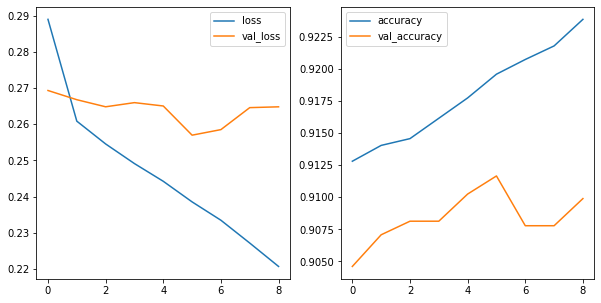

In [12]:
# Plot loss, accuracy, val_loss, val_accuracy
def plot_history(history):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.legend()
    plt.show()
plot_history(history)

In [13]:
train_preds = model.predict(padded_train)
dev_preds = model.predict(padded_dev)
test_preds = model.predict(padded_test)

train_preds = np.where(train_preds > 0.5, 1, 0)
dev_preds = np.where(dev_preds > 0.5, 1, 0)
test_preds = np.where(test_preds > 0.5, 1, 0)

train_preds = train_preds.flatten()
dev_preds = dev_preds.flatten()
test_preds = test_preds.flatten()

89/89 [==============================] - 0s 2ms/step


In [14]:
computeAllScores(train_preds, dev_preds, test_preds, False, True)

Accuracy Train:  0.926033421284081
Accuracy Dev:  0.9098908834917283
Accuracy Test:  0.915933872669715
Weighted F1 Train:  0.9072896267973604
Weighted F1 Dev:  0.8845786895133843
Weighted F1 Test:  0.8954286315412846
Macro F1 Train:  0.6506060481495184
Macro F1 Dev:  0.5995683484925232
Macro F1 Test:  0.6144708539745456
Micro F1 Train:  0.926033421284081
Micro F1 Dev:  0.9098908834917283
Micro F1 Test:  0.915933872669715
Weighted Recall Train:  0.926033421284081
Weighted Recall Dev:  0.9098908834917283
Weighted Recall Test:  0.915933872669715
Macro Recall Train:  0.6068955843969289
Macro Recall Dev:  0.5721455475923339
Macro Recall Test:  0.5834438873891246
Micro Recall Train:  0.926033421284081
Micro Recall Dev:  0.9098908834917283
Micro Recall Test:  0.915933872669715
Confusion Matrix Train: 
[[  434  1528]
 [  154 20624]]
Confusion Matrix Dev: 
[[  42  230]
 [  26 2543]]
Confusion Matrix Test: 
[[  45  205]
 [  34 2559]]
